# Assignment 6: Neural Networks

# Problem 1: The dataset

Loading the MNIST dataset from `torchvision.datasets`:

In [1]:
import csv

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
	root='data',
	train=True,
	download=True,
	transform=ToTensor()
)

test_data = datasets.MNIST(
	root='data',
	train=False,
	download=True,
	transform=ToTensor()
)

Wrapping the dataset in a `DataLoader`:

In [2]:
train_loader = DataLoader(
	train_data,
	batch_size=64,
)

test_loader = DataLoader(
	test_data,
	batch_size=64,
)

Plotting the first images from the training set:

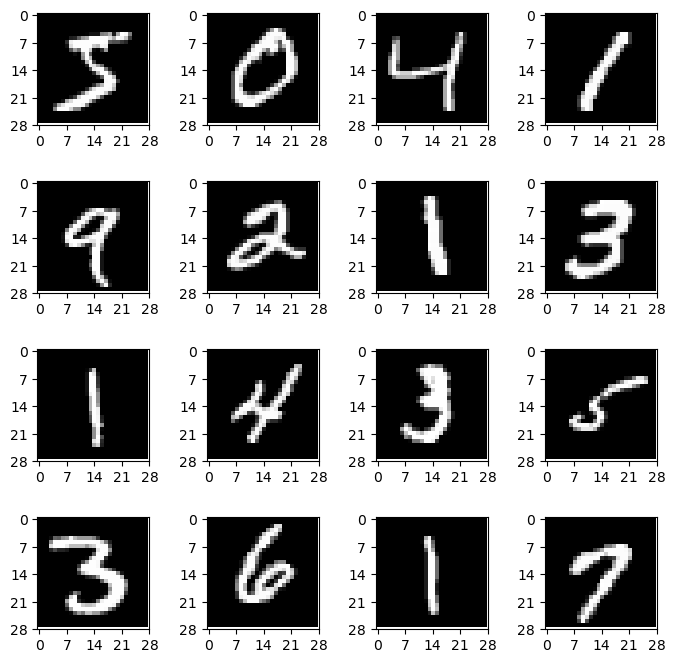

In [3]:
import matplotlib.pyplot as plt

images, _ = next(iter(train_loader))

ppr = 4  # plots per row

fig, ax = plt.subplots(
	ppr, ppr,
	figsize=(ppr * 2, ppr * 2)
)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i in range(ppr ** 2):
	ax[i // ppr, i % ppr].imshow(
		images[i].squeeze(),
		cmap='gray'
	)
	ax[i // ppr, i % ppr].set_xticks(
		range(0, 29, 7))
	ax[i // ppr, i % ppr].set_yticks(
		range(0, 29, 7))

plt.savefig('figures/mnist.png')

# Problem 2: Single hidden layer

## Designing the model

Creating a neural network model with a single hidden layer with ReLU activation.

Using SGD as optimizer and CrossEntropy as loss function. 

Also, defining the device to be used:

In [4]:
device = (
	"cuda"
	if torch.cuda.is_available()
	else "mps"
	if torch.backends.mps.is_available()
	else "cpu"
)
print(f"Using device: {device}")

Using device: mps


In [5]:
class FNN(nn.Module):
	def __init__(self):
		super(FNN, self).__init__()
		self.flatten = nn.Flatten()
		self.linear_stack = nn.Sequential(
			nn.Linear(28 * 28, 512),
			nn.ReLU(),
			nn.Linear(512, 10),
		)

	def forward(self, x):
		x = self.flatten(x)
		x = self.linear_stack(x)
		return x


model = FNN().to(device)

In [6]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
	model.parameters(),
	lr=1e-3
)

## Defining the training, testing, and evaluation functions

Defining the training of the model:

In [7]:
def train(dataloader, model, loss_fn, optimizer,
          logging=False):
	losses = []
	size = len(dataloader.dataset)
	model.train()
	for batch, (X, y) in enumerate(dataloader):
		X, y = X.to(device), y.to(device)

		pred = model(X)
		loss = loss_fn(pred, y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if batch % 100 == 0:
			losses.append(loss.item())
			if logging:
				current = batch * len(X)
				print(
					f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]"
				)
	return losses

Defining the testing of the model performance against the `test_data`:

In [8]:
def test(dataloader, model, loss_fn,
         logging=True):
	size = len(dataloader.dataset)
	num_batches = len(dataloader)
	model.eval()
	test_loss, correct = 0, 0
	with (torch.no_grad()):
		for X, y in dataloader:
			X, y = X.to(device), y.to(device)
			pred = model(X)
			test_loss += loss_fn(pred, y).item()
			correct += (
					pred.argmax(1) == y
			).type(torch.float).sum().item()
	test_loss /= num_batches
	accuracy = round(correct / size * 100, 4)
	if logging:
		print(f"\n accuracy: {accuracy:>0.1f}%")
		print(f" test loss: {test_loss:>8f}\n")
	return accuracy, test_loss

Defining the export of the accuracy data to a csv file:

In [9]:
def save_accuracy_data(
		filename, accuracy_list
):
	with open(filename, mode='w') as file:
		writer = csv.writer(file)
		writer.writerow(["epoch", "accuracy"])
		for epoch, accuracy in enumerate(
				accuracy_list):
			writer.writerow([epoch + 1, accuracy])

Defining the plotting of the training and test loss:

In [10]:
def plot_loss(
		train_loss, test_loss, epochs, title, filename
):
	epoch_length = len(train_loss) // len(test_loss)
	max_lines = 10
	epoch_step = max(1, len(epochs) // max_lines)
	plt.plot(train_loss, label="train")
	plt.plot(
		range(
			epoch_length,
			len(train_loss) + epoch_length,
			epoch_length
		),
		test_loss, label="test", marker='o'
	)
	selected_epochs = epochs[::epoch_step]
	for epoch in selected_epochs:
		plt.axvline(
			epoch * epoch_length,
			color='gray', linestyle='--', alpha=0.5
		)
	plt.xticks(
		[0] + list(range(
			epoch_length,
			len(train_loss) + 1,
			epoch_length * epoch_step
		)),
		[0] + list(selected_epochs)
	)

	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.title(title)
	plt.savefig(f"figures/{filename}")

## Training and evaluating the model

Training the model for 10 epochs and evaluating its performance:

In [11]:
epochs = range(1, 11)

train_loss = []
test_loss = []
accuracy_list = []
for t in epochs:
	print(f"training epoch {t}...")

	epoch_train_loss = train(
		train_loader, model, loss_fn, optimizer,
	)
	accuracy, epoch_test_loss = test(
		test_loader, model, loss_fn
	)

	train_loss.extend(epoch_train_loss)
	test_loss.append(epoch_test_loss)
	accuracy_list.append(accuracy)

	print(f"-------------------------------")

torch.save(
	model.state_dict(),
	"models/single_layer.pth"
)
print("training complete, model saved")

training epoch 1...

 accuracy: 64.7%
 test loss: 2.057574

-------------------------------
training epoch 2...

 accuracy: 73.5%
 test loss: 1.756412

-------------------------------
training epoch 3...

 accuracy: 77.0%
 test loss: 1.423048

-------------------------------
training epoch 4...

 accuracy: 80.3%
 test loss: 1.143246

-------------------------------
training epoch 5...

 accuracy: 82.5%
 test loss: 0.945467

-------------------------------
training epoch 6...

 accuracy: 84.0%
 test loss: 0.811005

-------------------------------
training epoch 7...

 accuracy: 85.3%
 test loss: 0.717343

-------------------------------
training epoch 8...

 accuracy: 86.1%
 test loss: 0.649470

-------------------------------
training epoch 9...

 accuracy: 86.7%
 test loss: 0.598392

-------------------------------
training epoch 10...

 accuracy: 87.2%
 test loss: 0.558716

-------------------------------
training complete, model saved


Saving and plotting the accuracy data:

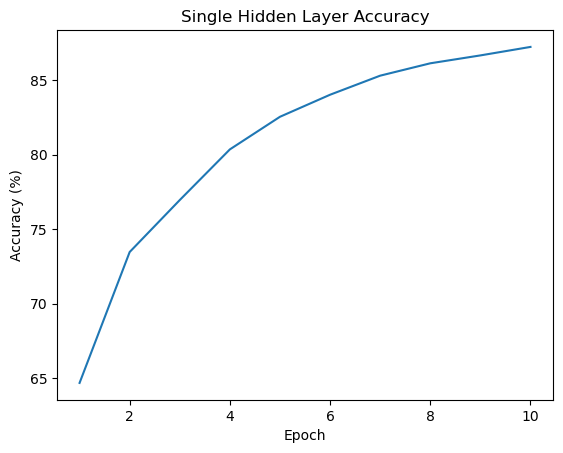

In [12]:
save_accuracy_data(
	"models/single_layer_accuracy.csv",
	accuracy_list
)

plt.plot(epochs, accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Single Hidden Layer Accuracy")
plt.savefig(
	"figures/single_layer_accuracy.png")

Plotting the training and test loss:

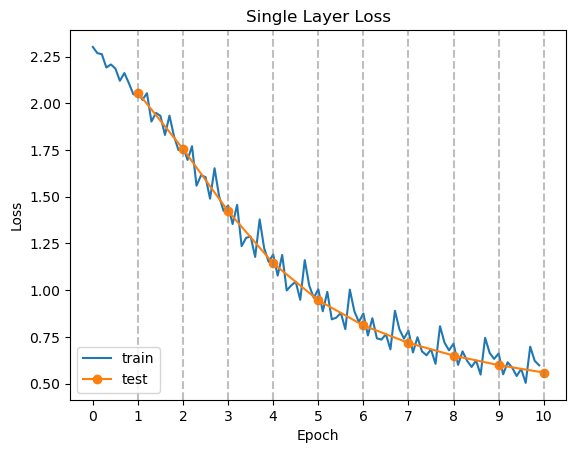

In [13]:
plot_loss(
	train_loss, test_loss, epochs,
	"Single Layer Loss",
	"single_layer_loss.png"
)

# Problem 3: Two hidden layers

## Designing the model

Creating a neural network model with two hidden layers with ReLU activation.

Reusing the CrossEntropy as loss function and using SGD with L2 regularization as optimizer.

Reusing the device definition:

In [14]:
class FNN2(nn.Module):
	def __init__(self):
		super(FNN2, self).__init__()
		self.flatten = nn.Flatten()
		self.linear_stack = nn.Sequential(
			nn.Linear(28 * 28, 500),
			nn.ReLU(),
			nn.Linear(500, 300),
			nn.ReLU(),
			nn.Linear(300, 10),
		)

	def forward(self, x):
		x = self.flatten(x)
		x = self.linear_stack(x)
		return x


model = FNN2().to(device)

In [15]:
optimizer = torch.optim.SGD(
	model.parameters(),
	lr=0.1,
	weight_decay=1e-4
)

## Training and evaluating the model

Train the model for 40 epochs and evaluate its performance:

In [16]:
epochs = range(1, 41)

train_loss = []
test_loss = []
accuracy_list = []
for t in epochs:
	print(f"training epoch {t}...")

	epoch_train_loss = train(
		train_loader, model, loss_fn, optimizer,
	)
	accuracy, epoch_test_loss = test(
		test_loader, model, loss_fn
	)

	train_loss.extend(epoch_train_loss)
	test_loss.append(epoch_test_loss)
	accuracy_list.append(accuracy)

	print(f"-------------------------------")

torch.save(
	model.state_dict(),
	"models/two_layer.pth"
)
print("training complete, model saved")

training epoch 1...

 accuracy: 93.5%
 test loss: 0.216005

-------------------------------
training epoch 2...

 accuracy: 95.3%
 test loss: 0.148263

-------------------------------
training epoch 3...

 accuracy: 96.5%
 test loss: 0.111650

-------------------------------
training epoch 4...

 accuracy: 97.2%
 test loss: 0.091003

-------------------------------
training epoch 5...

 accuracy: 97.4%
 test loss: 0.081240

-------------------------------
training epoch 6...

 accuracy: 97.5%
 test loss: 0.076302

-------------------------------
training epoch 7...

 accuracy: 97.6%
 test loss: 0.073811

-------------------------------
training epoch 8...

 accuracy: 97.7%
 test loss: 0.071659

-------------------------------
training epoch 9...

 accuracy: 97.8%
 test loss: 0.069926

-------------------------------
training epoch 10...

 accuracy: 97.8%
 test loss: 0.068368

-------------------------------
training epoch 11...

 accuracy: 97.8%
 test loss: 0.067690

------------------

Saving and plotting the accuracy data:

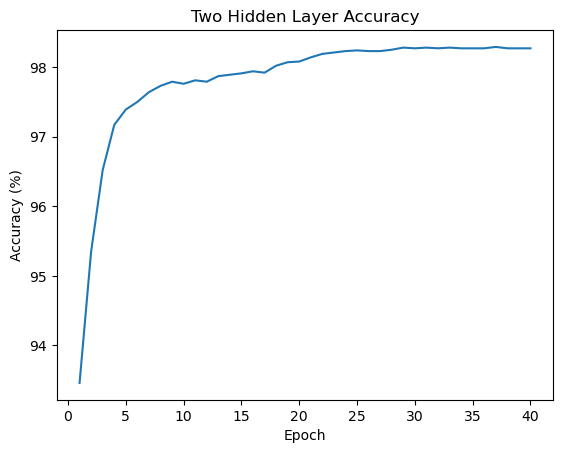

In [17]:
save_accuracy_data(
	"models/two_layer_accuracy.csv",
	accuracy_list
)
plt.plot(epochs, accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Two Hidden Layer Accuracy")
plt.savefig(
	"figures/two_layer_accuracy.png")

Plotting the training and test loss:

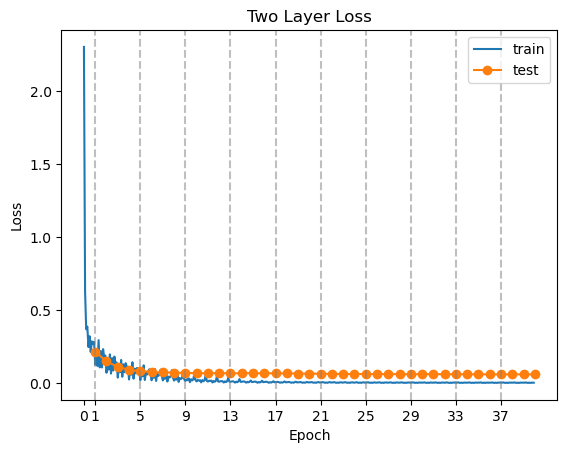

In [18]:
plot_loss(
	train_loss, test_loss, epochs,
	"Two Layer Loss",
	"two_layer_loss.png"
)

# Problem 4: Convolutional Neural Network

## Designing the model

Creating a convolutional neural network model with two convolutional layers and two fully connected layers.

Reusing the CrossEntropy as loss function and reusing the SGD with L2 regularization as optimizer.

Reusing the device definition:

In [19]:
class CNN(nn.Module):
	def __init__(self):
		super(CNN, self).__init__()
		self.conv_block = nn.Sequential(
			nn.Conv2d(
				1, 32,
				kernel_size=3, stride=1, padding=1
			),
			nn.BatchNorm2d(32),
			nn.ReLU(inplace=True),
			nn.Conv2d(
				32, 64,
				kernel_size=3, stride=1, padding=1
			),
			nn.BatchNorm2d(64),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
			nn.Conv2d(
				64, 128,
				kernel_size=3, stride=1, padding=1
			),
			nn.BatchNorm2d(128),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2)
		)

		self.linear_block = nn.Sequential(
			nn.Dropout(p=0.5),
			nn.Linear(128 * 7 * 7, 128),
			nn.BatchNorm1d(128),
			nn.ReLU(inplace=True),
			nn.Dropout(0.5),
			nn.Linear(128, 64),
			nn.BatchNorm1d(64),
			nn.ReLU(inplace=True),
			nn.Dropout(0.5),
			nn.Linear(64, 10)
		)

	def forward(self, x):
		x = self.conv_block(x)
		x = x.view(x.size(0), -1)
		x = self.linear_block(x)
		return x


model = CNN().to(device)

In [20]:
optimizer = torch.optim.SGD(
	model.parameters(),
	lr=0.01,
	weight_decay=1e-4
)

## Training and evaluating the model

Train the model for 40 epochs and evaluate its performance:

In [ ]:
epochs = range(1, 41)

train_loss = []
test_loss = []
accuracy_list = []
for t in epochs:
	print(f"training epoch {t}...")

	epoch_train_loss = train(
		train_loader, model, loss_fn, optimizer,
	)
	accuracy, epoch_test_loss = test(
		test_loader, model, loss_fn
	)

	train_loss.extend(epoch_train_loss)
	test_loss.append(epoch_test_loss)
	accuracy_list.append(accuracy)

	print(f"-------------------------------")

torch.save(
	model.state_dict(),
	"models/cnn.pth"
)
print("training complete, model saved")

training epoch 1...

 accuracy: 97.3%
 test loss: 0.153333

-------------------------------
training epoch 2...


Saving and plotting the accuracy data:

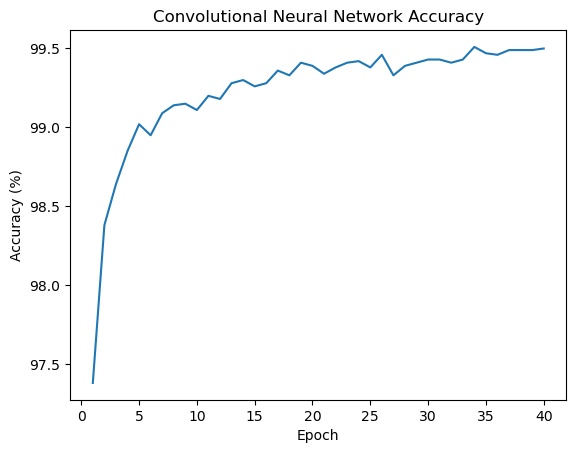

In [256]:
save_accuracy_data("models/cnn_accuracy.csv",
                   accuracy_list)
plt.plot(epochs, accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Convolutional Neural Network Accuracy")
plt.savefig("figures/cnn_accuracy.png")

Plotting the training and test loss:

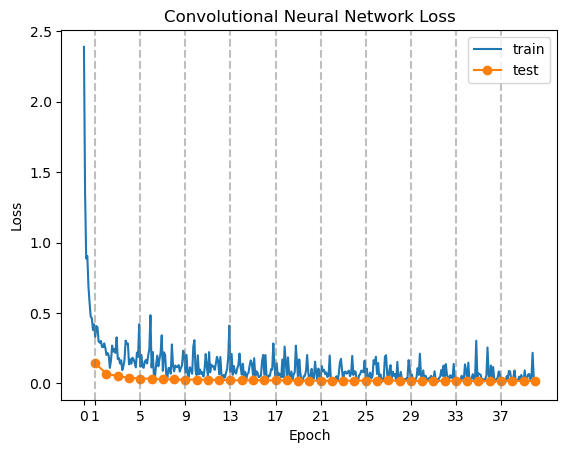

In [257]:
plot_loss(
	train_loss, test_loss, epochs,
	"Convolutional Neural Network Loss",
	"cnn_loss.png"
)